# Specific Test IV. Exploring Equivariant Neural Networks

**Task:** Use an Equivariant Neural Network of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.

**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

## Strategy

For the purpose of this test, an Equivariant ResNet model was used. The model built here is similar to ResNet34 but using the equivariant layers. The model is built using  basic blocks that contains two Equivariant Conv layers, batch-normalisation, relu and a skip connection between the input data and the data after the two convolutions after batch-normalisation and before relu. These blocks are arranged into multiple layers to create the resnet model.

The network is trained for 15 epochs with a batch size of 32. The network is trained using the Adam optimizer with a learning rate of 0.001 and a weight decay of 0.0001. Also StepLR scheduler is used to reduce the learning rate by a factor of 0.1 every 4 epochs.

The dataset is split in a 9:1 train-test ratio. The training set is augmented using ColorJitter and RandomRotation(180). The test set is not augmented.

Since the below model performs well, more complicated models were not explored.

## Results

**ROC-AUC Score:** 0.999952

**Training Curve:**

<img src="../results/test-4-training-plot.png" alt="Training plot"/>

**ROC Curve:**

<img src="../results/test-4-roc-plot.png" alt="ROC plot"/>

## Importing Library

In [5]:
!pip install e2cnn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from e2cnn import gspaces
from e2cnn import gspaces, nn as e2nn
from e2cnn.nn.modules.equivariant_module import EquivariantModule
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Data

In [7]:
base_dir = '../datasets/test4/lenses'

train_df = pd.DataFrame(columns = ['path', 'label'])

label_map = {'no_sub':0, 'sub':1}
val_label_map = {0:'no_sub', 1:'sub'}

for i in label_map.keys():
    entries = [os.path.join(base_dir, i, j) for j in os.listdir(os.path.join(base_dir, i))]
    temp_df = pd.DataFrame({'path':entries, 'label':i})
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

train_df.head()

,path,label
0,../datasets/test4/lenses/no_sub/image_17478751...,no_sub
1,../datasets/test4/lenses/no_sub/image_58501840...,no_sub
2,../datasets/test4/lenses/no_sub/image_20642528...,no_sub
3,../datasets/test4/lenses/no_sub/image_22438675...,no_sub
4,../datasets/test4/lenses/no_sub/image_27048203...,no_sub


In [8]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Train split:\n{train_df['label'].value_counts()}\n")
print(f"Test split:\n{test_df['label'].value_counts()}")

Train split:
sub       4500
no_sub    4500
Name: label, dtype: int64

Test split:
sub       500
no_sub    500
Name: label, dtype: int64


In [9]:
class Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]['label']
        label = label_map[label]
        
        return img, label

In [10]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomRotation(180),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = Dataset(train_df, transform=train_transforms)
test_dataset = Dataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

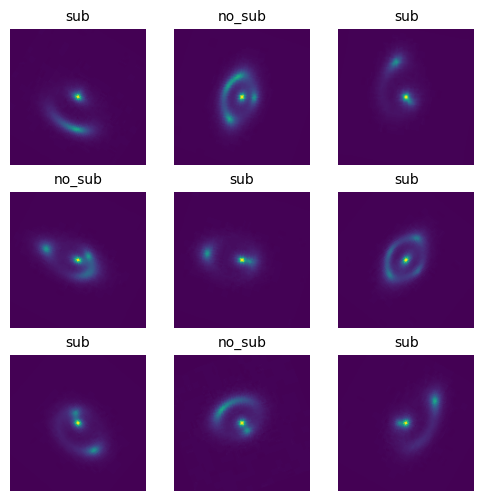

In [11]:
def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*4 + j]
            label = labels[i*4 + j].item()
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = [k for k, v in class_map.items() if v == label][0]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, label_map)

## Defining Model

In [12]:
class EquivariantBasicBlock(EquivariantModule):

    def __init__(self, in_type, out_type, stride= 1):
        super().__init__()

        self.out_type = out_type

        self.conv1 = e2nn.R2Conv(in_type, out_type, kernel_size=3, stride= stride, padding=1)
        self.conv2 = e2nn.R2Conv(out_type, out_type, kernel_size=3, stride= 1, padding=1)
        self.bn1 = e2nn.InnerBatchNorm(out_type)
        self.bn2 = e2nn.InnerBatchNorm(out_type)
        self.relu = e2nn.ReLU(out_type, inplace= True)
        
        if stride != 1:
            self.downsample = e2nn.SequentialModule(
                e2nn.R2Conv(in_type, out_type, kernel_size=1, stride= stride),
                e2nn.InnerBatchNorm(out_type))
        else:
            self.downsample = e2nn.SequentialModule(e2nn.R2Conv(in_type, out_type, kernel_size=1, stride= 1))
            
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(x)
        out = self.relu(out)

        return out
    
    def evaluate_output_shape(self, input_shape):
        
        # # compute the output shape of the first convolution
        out = self.conv1.evaluate_output_shape(input_shape)
        # # compute the output shape of the second convolution
        out = self.conv2.evaluate_output_shape(out)
        return out

class EquivariantResNet(torch.nn.Module):
    
    def __init__(self, n_classes = 2):
        super().__init__()

        gspace = gspaces.Rot2dOnR2(N= 4)
        self.in_type = e2nn.FieldType(gspace, [gspace.trivial_repr])
        self.out_type = e2nn.FieldType(gspace, [gspace.regular_repr] * 64)

        self.inplanes = 64
        self.conv1 = e2nn.R2Conv(self.in_type, self.out_type, kernel_size=7, stride= 2, padding=3)
        self.bn1 = e2nn.InnerBatchNorm(self.out_type)
        self.relu = e2nn.ReLU(self.out_type, inplace= True)
        self.maxpool = e2nn.SequentialModule(
            e2nn.R2Conv(self.out_type, self.out_type, kernel_size=3, stride=2, padding=1),
            e2nn.InnerBatchNorm(self.out_type),
            e2nn.ReLU(self.out_type, inplace= True)
        )

        in_type = self.out_type
        self.out_type = e2nn.FieldType(gspace, [gspace.regular_repr] * 12)
        self.layer1 = self._make_layer(3, in_type, self.out_type, stride= 1)
        
        in_type = self.out_type
        self.out_type = e2nn.FieldType(gspace, [gspace.regular_repr] * 24)
        self.layer2 = self._make_layer(4, in_type, self.out_type, stride= 2)

        in_type = self.out_type
        self.out_type = e2nn.FieldType(gspace, [gspace.regular_repr] * 48)
        self.layer3 = self._make_layer(6, in_type, self.out_type, stride= 2)

        in_type = self.out_type
        self.out_type = e2nn.FieldType(gspace, [gspace.regular_repr] * 96)
        self.layer4 = self._make_layer(4, in_type, self.out_type, stride= 2)

        self.gpool = e2nn.PointwiseAvgPool(self.out_type, kernel_size= 3, stride= 1)

        self.fc = torch.nn.Linear(3456, n_classes, bias= True)

    def _make_layer(self, nblocks, in_type, out_type, stride=1):
        layers = []
        layers.append(EquivariantBasicBlock(in_type, out_type, stride= stride))
        for _ in range(1, nblocks):
            layers.append(EquivariantBasicBlock(out_type, out_type, stride= 1))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = e2nn.GeometricTensor(x, self.in_type)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.gpool(out)
        out = out.tensor
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

## Hyper-parameters and Training

In [9]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_val_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), '../models/test-4-model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc, best_acc

In [10]:
model = EquivariantResNet(n_classes=2).to(device)

epochs = 15
lr = 0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/home/gautham/.local/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [11]:
train_losses, train_acc, test_losses, test_acc, best_acc = train(model, epochs, optimizer, loss_function, scheduler, device, train_loader, test_loader)

Epoch: 1


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]


Train Loss: 0.705, Train Acc: 0.524, Test Loss: 0.663, Train Acc: 0.565

Epoch: 2


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s]


Train Loss: 0.605, Train Acc: 0.610, Test Loss: 0.627, Train Acc: 0.561

Epoch: 3


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.27it/s]


Train Loss: 0.386, Train Acc: 0.782, Test Loss: 0.334, Train Acc: 0.828

Epoch: 4


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]


Train Loss: 0.108, Train Acc: 0.954, Test Loss: 0.051, Train Acc: 0.985

Epoch: 5


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]


Train Loss: 0.059, Train Acc: 0.977, Test Loss: 0.049, Train Acc: 0.982

Epoch: 6


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.31it/s]


Train Loss: 0.050, Train Acc: 0.982, Test Loss: 0.057, Train Acc: 0.983

Epoch: 7


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.35it/s]


Train Loss: 0.031, Train Acc: 0.989, Test Loss: 0.030, Train Acc: 0.991

Epoch: 8


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.28it/s]


Train Loss: 0.026, Train Acc: 0.991, Test Loss: 0.036, Train Acc: 0.986

Epoch: 9


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.58it/s]


Train Loss: 0.027, Train Acc: 0.990, Test Loss: 0.029, Train Acc: 0.989

Epoch: 10


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.92it/s]


Train Loss: 0.024, Train Acc: 0.991, Test Loss: 0.030, Train Acc: 0.989

Epoch: 11


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.77it/s]


Train Loss: 0.025, Train Acc: 0.991, Test Loss: 0.025, Train Acc: 0.993

Epoch: 12


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.79it/s]


Train Loss: 0.024, Train Acc: 0.990, Test Loss: 0.027, Train Acc: 0.990

Epoch: 13


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.74it/s]


Train Loss: 0.025, Train Acc: 0.990, Test Loss: 0.032, Train Acc: 0.989

Epoch: 14


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.85it/s]


Train Loss: 0.023, Train Acc: 0.991, Test Loss: 0.026, Train Acc: 0.992

Epoch: 15


Test	: 100%|██████████| 32/32 [00:02<00:00, 12.73it/s]


Train Loss: 0.022, Train Acc: 0.992, Test Loss: 0.026, Train Acc: 0.991



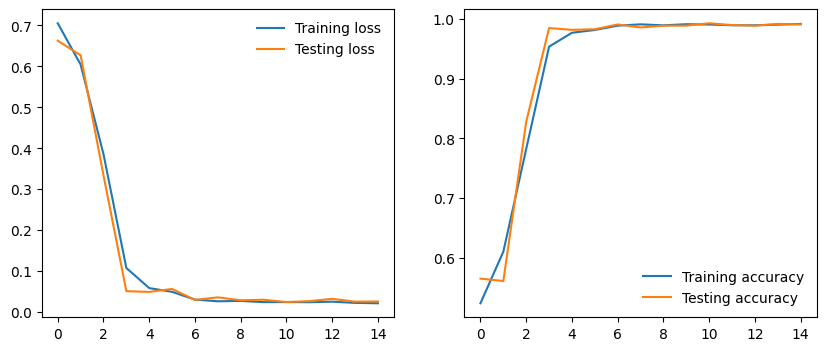

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Testing accuracy')
plt.legend(frameon=False)

## Testing

The best model is loaded for testing and the results are plotted.

In [15]:
model = EquivariantResNet(n_classes=2).to(device)
model.load_state_dict(torch.load('../models/test-4-model.pth'))

<All keys matched successfully>

In [16]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 32/32 [00:03<00:00, 10.31it/s]


In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class, target_names=label_map.keys()))

              precision    recall  f1-score   support

      no_sub       0.98      1.00      0.99       500
         sub       1.00      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



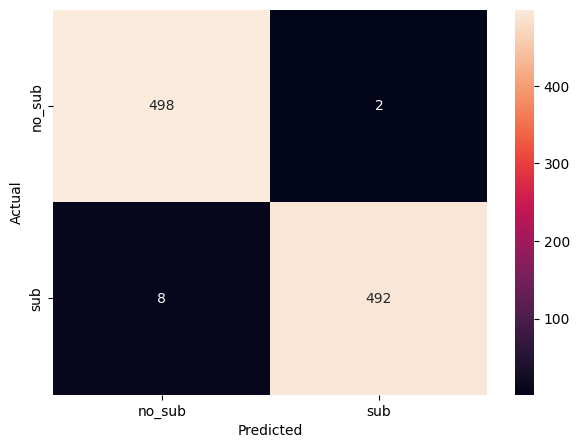

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
print(f"ROC-AUC Score: {roc_auc_score(y_true, np.array(y_pred_prob)[:,1], multi_class='ovr')}")

ROC-AUC Score: 0.9994719999999999


no_sub   ROC-AUC: 0.9994999999999999
sub      ROC-AUC: 0.9994719999999999


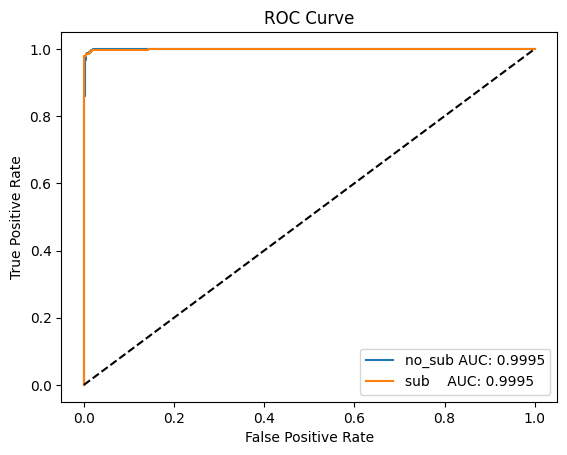

In [20]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(2):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()